# Simple pendulum using Lagrange's equation

Defines a LagrangianPendulum class that is used to generate basic pendulum plots from solving Lagrange's equations.

* Last revised 17-Mar-2019 by Dick Furnstahl (furnstahl.1@osu.edu).

## Euler-Lagrange equation

For a simple pendulum, the Lagrangian with generalized coordinate $\phi$ is

$\begin{align}
  \mathcal{L} = \frac12 m L^2 \dot\phi^2 - mgL(1 - \cos\phi)
\end{align}$

The Euler-Lagrange equation is

$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot\phi} = \frac{\partial\mathcal L}{\partial\phi}
 \quad\Longrightarrow\quad
 m L^2 \ddot \phi = -mgL\sin\phi
  \ \mbox{or}\ \ddot\phi = - \omega_0^2\sin\phi = 0
  \;.
\end{align}$

## Hamilton's equations

The generalized momentum corresponding to $\phi$ is

$\begin{align}
   \frac{\partial\mathcal{L}}{\partial \dot\phi} = m L^2 \dot\phi \equiv p_\phi
   \;.
\end{align}$

We can invert this equation to find $\dot\phi = p_\phi / m L^2$.
Constructing the Hamiltonian by Legendre transformation we find 

$\begin{align}
  \mathcal{H} &= \dot\phi p_\phi  - \mathcal{L} \\
              &= \frac{p_\phi^2}{m L^2} - \frac12 m L^2 \dot\phi^2 + mgL(1 - \cos\phi) \\
              &= \frac{p_\phi^2}{2 m L^2} + mgL(1 - \cos\phi)
              \;.
\end{align}$

Thus $\mathcal{H}$ is simply $T + V$.  Hamilton's equations are

$\begin{align}
  \dot\phi &= \frac{\partial\mathcal{H}}{\partial p_\phi} = \frac{p_\phi}{m L^2} \\
  \dot p_\phi &= -\frac{\partial\mathcal{H}}{\partial \phi} = -mgL \sin\phi 
  \;.
\end{align}$

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.integrate import odeint, solve_ivp

import matplotlib.pyplot as plt

In [3]:
# The dpi (dots-per-inch) setting will affect the resolution and how large
#  the plots appear on screen and printed.  So you may want/need to adjust 
#  the figsize when creating the figure.
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook

# Change the common font size (smaller when higher dpi)
font_size = 10
plt.rcParams.update({'font.size': font_size})

## Pendulum class and utility functions

In [16]:
class LagrangianPendulum():
    """
    Pendulum class implements the parameters and Lagrange's equations for 
     a double pendulum (no driving or damping).
     
    Parameters
    ----------
    L1 : float
        length of pendulum1
    L2 : float
        length of pendulum2
    g : float
        gravitational acceleration at the earth's surface
    mass1 : float
        mass of pendulum 1
    mass2 : float
        mass of pendulum 2   

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    def __init__(self, L1=1., L2=1., g=1., mass1=1., mass2=1.
                ):
        self.L1 = L1
        self.L2 = L2
        self.g = g
        self.m1 = mass1
        self.m2 = mass2
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dphi1/dt d^2phi1/dt^2
         dphi2/dt d^2phi2/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            A 4-component vector with
                y[0] = phi1(t), y[1] = dphi1/dt
                y[2] = phi2(t), y[3] = dphi2(t)
        cos, sin: parameters used to aid in the calculation
            
        Returns
        -------
        
        """
        cos = np.cos(y[0] - y[2])
        sin = np.sin(y[0] - y[2])
        
        # expressions for the second derivatives from the Euler-Lagrange equations:
        phi1_double_dot = (self.m2 * self.g * np.sin(y[0]) * cos - \
                            self.m2 * sin * (self.L1 * y[1]**2) - \
                            (self.m1 + self.m2) * self.g * np.sin(y[0])) \
                            / (self.L1 * (self.m1 + self.m2 * sin**2))
        
        phi2_double_dot = ((self.m1 + self.m2) * (self.L1 * y[1]**2 * sin - \
                            self.g * np.sin(y[2]) + self.g * np.sin(y[0]) * cos) + \
                            self.m2 * self.L2 * y[3]**2 * sin * cos) \
                            / (self.L2 * (self.m1 + self.m2 * sin**2))
        
        return [y[1], phi1_double_dot, \
                y[3], phi2_double_dot]
    
    def solve_ode(self, t_pts, phi1_0, phi1_dot_0, phi2_0, phi2_dot_0,
                  abserr=1.0e-9, relerr=1.0e-9):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [phi1_0, phi1_dot_0, phi2_0, phi2_dot_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        phi1, phi1_dot, phi2, phi2_dot = solution.y

        return phi1, phi1_dot, phi2, phi2_dot

In [17]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [18]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

In [19]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

## Make simple pendulum plots 

In [20]:
# Labels for individual plot axes
phi_vs_time_labels = (r'$t$', r'$\phi(t)$')
phi_dot_vs_time_labels = (r'$t$', r'$d\phi/dt(t)$')
state_space_labels = (r'$\phi$', r'$d\phi/dt$')

# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 50.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

L1 = 1.
L2 = 1.
g = 1.
mass1 = 1.
mass2 = 1.

# Instantiate a pendulum 
p1 = LagrangianPendulum(L1=L1, L2=L2, g=g, mass1=mass1, mass2=mass2)


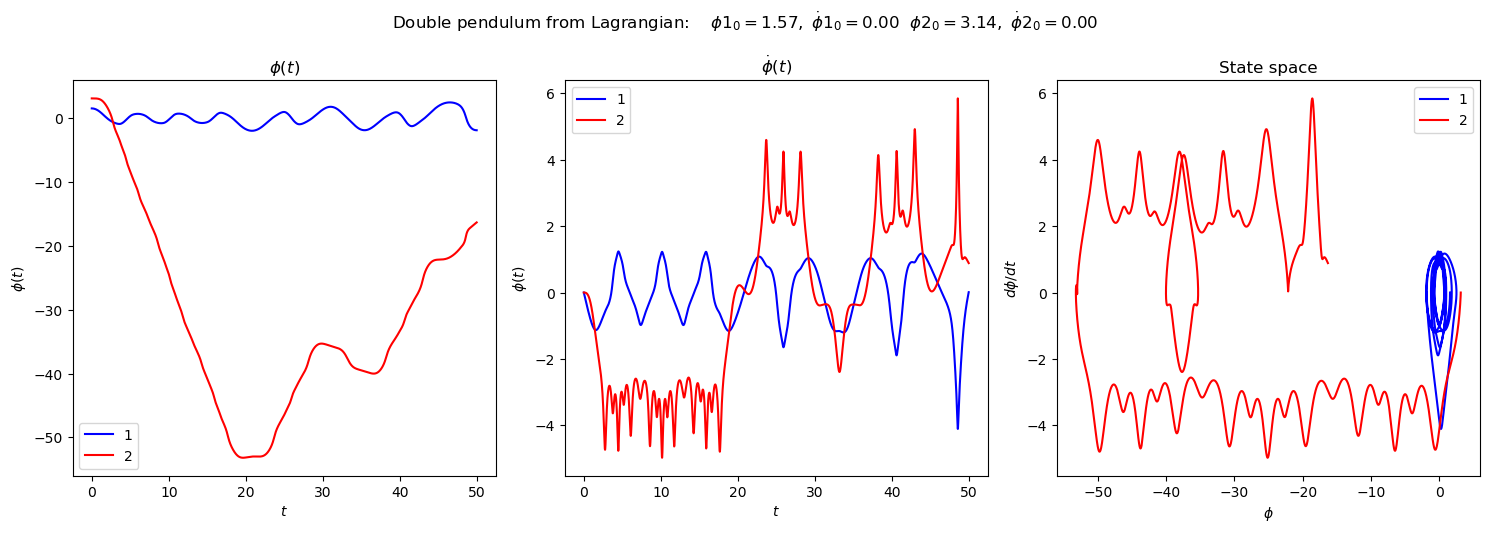

In [32]:
# both plots: same initial conditions
phi1_0 = (1./2.)*np.pi
phi1_dot_0 = 0.
phi2_0 = np.pi
phi2_dot_0 = 0.
phi1, phi1_dot, phi2, phi2_dot = p1.solve_ode(t_pts, phi1_0, phi1_dot_0, phi2_0, phi2_dot_0)



# start the plot!
fig = plt.figure(figsize=(15,5))
overall_title = 'Double pendulum from Lagrangian:  ' + \
                rf'  $\phi1_0 = {phi1_0:.2f},$' + \
                rf' $\dot\phi1_0 = {phi1_dot_0:.2f}$' + \
                rf'  $\phi2_0 = {phi2_0:.2f},$' + \
                rf' $\dot\phi2_0 = {phi2_dot_0:.2f}$' + \
                '\n'     # \n means a new line (adds some space here)
fig.suptitle(overall_title, va='baseline')

# Now plot phi1 and phi2 seperately, with the angle, angular velocity, and state space
# plotted for each to give a total of 6 lines on 3 plots

# first plot: phi plot 
ax_a = fig.add_subplot(1,3,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi1[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='blue',
            label='1', 
            title=r'$\phi(t)$', 
            ax=ax_a)    
plot_y_vs_x(t_pts[start : stop], phi2[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='red',
            label='2', 
            title=None, 
            ax=ax_a)    
                              
# second plot: phi_dot plot 
ax_b = fig.add_subplot(1,3,2)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi1_dot[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='blue',
            label='1', 
            title=r'$\dot\phi(t)$', 
            ax=ax_b)   
plot_y_vs_x(t_pts[start : stop], phi2_dot[start : stop], 
            axis_labels=phi_vs_time_labels, 
            color='red',
            label='2', 
            title=None, 
            ax=ax_b)    


# third plot: state space plot from t=30 to t=50   
ax_c = fig.add_subplot(1,3,3)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(phi1[start : stop], phi1_dot[start : stop], 
            axis_labels=state_space_labels, 
            color='blue',
            label='1', 
            title='State space', 
            ax=ax_c)    
plot_y_vs_x(phi2[start : stop], phi2_dot[start : stop], 
            axis_labels=state_space_labels, 
            color='red',
            label='2', 
            title='State space', 
            ax=ax_c)   

fig.tight_layout()
fig.savefig('double_pendulum_Lagrange.png', bbox_inches='tight')  

The state space plot shows the state space from t = 30 to t = 50, which should be after the transients have died out (for a non-chaotic system).  As the state space is still not periodic at this late time, the system is chaotic.

Now trying the power spectrum, plotting only positive frequencies and cutting off the lower peaks:

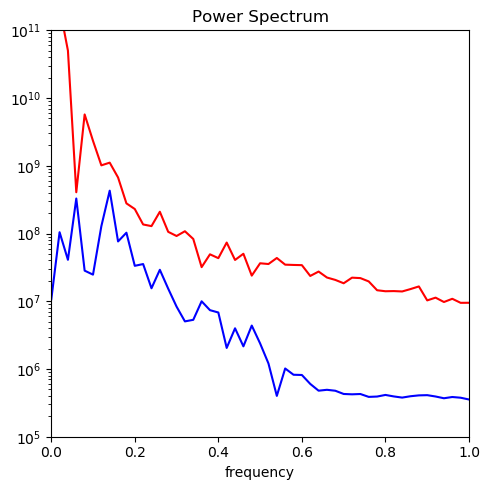

In [35]:
start, stop = start_stop_indices(t_pts, t_start, t_end)    
signal1 = phi1[start:stop]
power_spectrum1 = np.abs(np.fft.fft(signal1))**2
freqs1 = np.fft.fftfreq(signal1.size, delta_t)
idx1 = np.argsort(freqs1)

signal2 = phi2[start:stop]
power_spectrum2 = np.abs(np.fft.fft(signal2))**2
freqs2 = np.fft.fftfreq(signal2.size, delta_t)
idx2 = np.argsort(freqs2)

fig_ps = plt.figure(figsize=(5,5))
ax_ps = fig_ps.add_subplot(1,1,1)
ax_ps.semilogy(freqs1[idx1], power_spectrum1[idx1], color='blue')
ax_ps.semilogy(freqs2[idx2], power_spectrum2[idx2], color='red')
ax_ps.set_xlim(0, 1.)
ax_ps.set_ylim(1.e5, 1.e11)
ax_ps.set_xlabel('frequency')
ax_ps.set_title('Power Spectrum')

fig_ps.tight_layout()